In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv("stations\export-r202_test_wifi-1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)

# Keep only the last 1 year of data
one_year_ago = df.index.max() - pd.DateOffset(years=1)
df = df[df.index >= one_year_ago]

# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp","location","pm_10"], inplace=True, errors="ignore")

# Resample to hourly and fill missing values

# Remove outliers using IQR
Q1 = df["pm_2_5"].quantile(0.25)
Q3 = df["pm_2_5"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)]

Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]
print(df)
df.interpolate(method="linear", inplace=True)

# df = df.resample("D").mean().fillna(method="ffill")

# ✅ ปรับขนาดข้อมูลเป็น 4 ช่วงต่อวัน (ทุก 6 ชั่วโมง)
df = df.resample("6H").mean()

# ✅ เพิ่ม Lag Features หลายระดับ (Short-Term & Long-Term) สำหรับ 4 ช่วงต่อวัน
for lag in [
    4 * 7 + 4,
    4 * 7 + 8,
    4 * 7 + 12,
    4 * 7 + 28,
    4 * 7 + 56,
]:  # 1 วัน, 2 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)

# ✅ เพิ่ม Rolling Mean และ Rolling Std หลายระดับ
for window in [4, 12, 28, 56]:  # 1 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7*4).rolling(window=window, min_periods=1).mean()
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7*4).rolling(window=window, min_periods=1).std()
    )
    # df[f"temperature_rollmean{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    # )
    # df[f"temperature_rollstd{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    # )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7*4).rolling(window=window, min_periods=1).mean()
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7*4).rolling(window=window, min_periods=1).std()
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7*4).rolling(window=window, min_periods=1).mean()
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7*4).rolling(window=window, min_periods=1).std()
    )

df = df.drop(columns=["temperature","humidity"])
df = df.asfreq("6H").fillna(method="bfill")  # เติมข้อมูลก่อนแบ่ง
# df =df[-365:]


# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง)
train = df.iloc[:-7*4]  # แบ่ง train
test = df.iloc[-7*4:]  # แบ่ง test


# ✅ เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"]
train = train[selected_features]
test = test[selected_features]

                      humidity     pm_2_5  temperature
timestamp                                             
2024-02-11 00:00:00  99.900002  31.933333    27.228334
2024-02-11 01:00:00  99.900002  32.200000    27.100000
2024-02-11 02:00:00  99.900002  32.083333    26.966667
2024-02-11 03:00:00  99.900002  25.700000    26.976667
2024-02-11 04:00:00  99.900002  20.716667    26.966667
...                        ...        ...          ...
2025-02-10 20:00:00  97.526667  25.900000    26.863334
2025-02-10 21:00:00  98.068333  26.366667    26.731667
2025-02-10 22:00:00  98.551667  26.416667    26.723333
2025-02-10 23:00:00  99.050001  29.365385    26.413462
2025-02-11 00:00:00  99.900002  31.100000    25.766102

[7784 rows x 3 columns]


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\teera\AppData\Local\Programs\Python\Python39\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\teera\AppData\Local\Programs\Python\Python39\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode characters in position 285-302: character maps to <undefined>
Call stack:
  File "C:\Users\teera\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\teera\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\jupyter\venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\jupyter\venv\lib\site-packages\traitlets\config\application.py", line 1075, in launc

In [8]:
len(train)

1437

In [9]:
# ✅ เพิ่ม fold เป็น 5 เพื่อให้โมเดล Generalize ขึ้น
experiment = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fh=7*4,  # Forecast horizon = 7 days (28 periods)
    fold=5,
    seasonal_period="6H",
    verbose=True,
)
test.index = test.index.to_period("6H")

# ✅ ลองโมเดล ARIMA ก่อน
arima_model = create_model("arima")
# arima_model = tune_model(arima_model)
# final_arima = finalize_model(arima_model)

# # Predict using the finalized model
# X_forecast = test.drop(columns=["pm_2_5"])

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1437, 40)"
5,Transformed data shape,"(1437, 40)"
6,Transformed train set shape,"(1409, 40)"
7,Transformed test set shape,"(28, 40)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24 00:00,1.8205,1.6308,13.9814,16.3407,1.6512,0.6752,-1.3667
1,2024-12-31 00:00,1.2103,1.0998,9.3005,11.0319,0.4490,0.3768,-0.1428
2,2025-01-07 00:00,0.9340,0.8928,7.2401,9.0421,0.2022,0.1975,-1.2539
3,2025-01-14 00:00,2.8346,2.5985,21.9286,26.2502,1.8178,0.6677,-2.2806
4,2025-01-21 00:00,1.7433,1.5963,13.7315,16.4712,0.4906,0.7058,-1.6690
Mean,NaT,1.7085,1.5636,13.2364,15.8272,0.9222,0.5246,-1.3426
SD,NaT,0.6527,0.5902,5.0557,5.9724,0.6726,0.2024,0.6978


In [10]:

final_arima = finalize_model(arima_model)


# Predict using the finalized model

X_forecast = test.drop(columns=["pm_2_5"])

MAE: 12.16
MAPE: 65.64%
R2: -4.84
accurent: 34.36


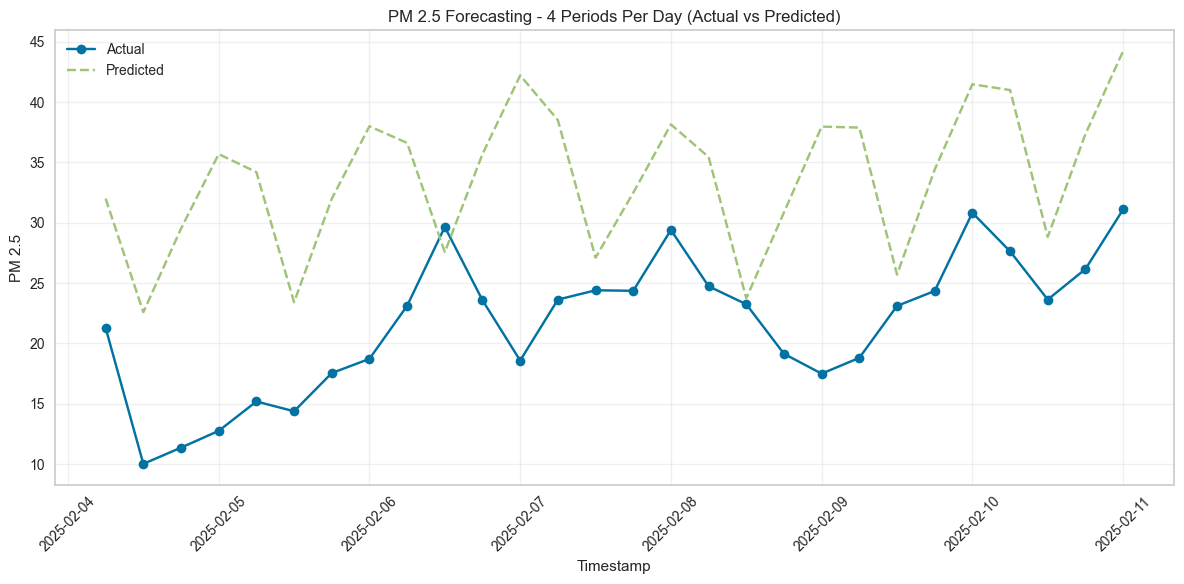

In [11]:
predictions = predict_model(final_arima, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
tune_arima_model = tune_model(arima_model)

final_model = finalize_model(tune_arima_model)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24 00:00,0.9759,0.8574,7.4952,8.5911,0.7371,0.4698,0.3458
1,2024-12-31 00:00,1.2920,1.1857,9.9278,11.8939,0.4040,0.4018,-0.3283
2,2025-01-07 00:00,1.7505,1.5261,13.5696,15.4555,0.3586,0.4568,-5.5850
3,2025-01-14 00:00,1.6099,1.4332,12.4541,14.4782,1.0022,0.4978,0.0020
4,2025-01-21 00:00,1.0984,0.9550,8.6516,9.8542,0.3739,0.3479,0.0447
Mean,NaT,1.3453,1.1915,10.4197,12.0546,0.5752,0.4348,-1.1042
SD,NaT,0.2948,0.2600,2.2795,2.6193,0.2551,0.0535,2.2506


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


MAE: 5.28
MAPE: 33.35%
R2: -0.58
accurent: 66.65


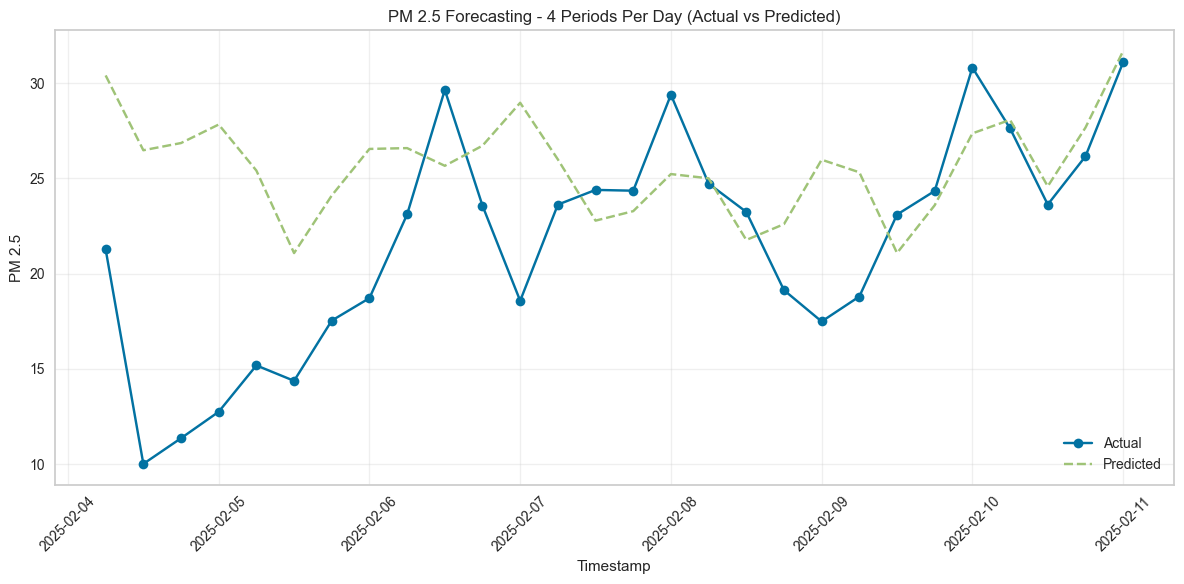

In [13]:
predictions = predict_model(final_model, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
X_forecast.to_csv("6H_X_feature/export-r202_test_wifi-1h.csv", encoding="utf-8-sig")

In [15]:
train.to_csv("6H_train/export-r202_test_wifi-1h.csv", encoding="utf-8-sig")

In [16]:
save_model(final_arima, "models/6H_export-r202_test_wifi-1h")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(seasonal_order=(0,
                                                                                                                                                       1,
                                                                                                                                                       0,
                                                                                                                                                       4)))]))]))]))]),
 'models